We are going to find some pattern of the data by using some unsupervised machine learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
data = pd.read_csv('Wholesale customers data.csv')

In [8]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [9]:
data.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


In [11]:
data.drop(columns=['Channel','Region'],inplace=True)

In [21]:
# Select three indices of your choice you wish to sample from the dataset
indices = [22,154,430]
data.loc[indices]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
22,31276,1917,4469,9408,2381,4334
154,622,55,137,75,7,8
430,3097,4230,16483,575,241,2080


In [17]:
data.shape

(440, 6)

In [18]:
data.keys()

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

In [28]:
sample = pd.DataFrame(data.loc[indices],columns=data.columns)

In [29]:
sample.reset_index(drop=True)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,31276,1917,4469,9408,2381,4334
1,622,55,137,75,7,8
2,3097,4230,16483,575,241,2080


In [32]:
percentile_rank=round(sample.rank(axis=0,pct=True)*100,1)

In [33]:
percentile_rank

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
22,100.0,66.7,66.7,100.0,100.0,100.0
154,33.3,33.3,33.3,33.3,33.3,33.3
430,66.7,100.0,100.0,66.7,66.7,66.7


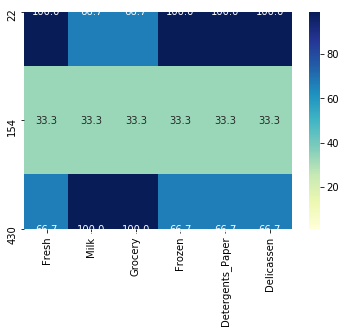

In [37]:
sns.heatmap(percentile_rank,annot=True,vmax=99,vmin=1,cmap='YlGnBu',fmt='.1f')
plt.show()

- Samples: - 0: This customer ranks above the 100th percentile for annual spending amounts in Fresh, Frozen, and the Delicatessen categories. These features along with above average spending for detergents_paper could lead us to believe this customer is a market. Markets generally put an emphasis on having a large variety of fresh foods available and often contain a delicatessen or deli.

- 1: On the opposite side of the spectrum, this customer ranks in the bottom 10th percentile across all product categories. It's highest ranking category is 'Fresh' which might suggest it is a small cafe or similar.

- 2: Our last customer spends a lot in the Fresh and Frozen categories but moreso in the latter. I would suspect this is a wholesale retailer because of the focus on Fresh and Frozen foods.

## Data Visualizations.

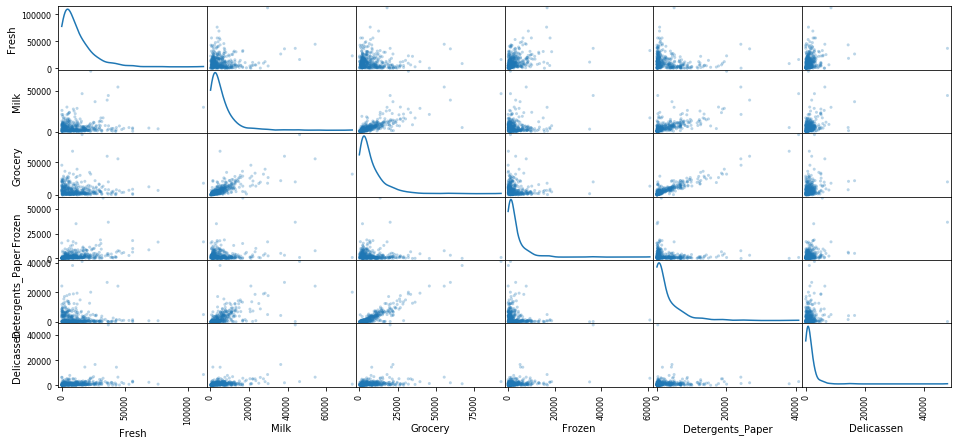

In [39]:
pd.plotting.scatter_matrix(data,alpha=0.3,figsize=(16,7),diagonal='kde')
plt.ticklabel_format()
plt.show()

Milk showed some signs of correlation for about half of the features . The pair of features with the highest correlation are Detergents_Paper and Grocery which intuitively makes sense as many people shop for both when they go "grocery shopping." One other visible point to note is how many of the points are around 0 for features compared to Delicatessen. The data for all of these features are right-skewed with many points however at the origin or near it and long tails.

## Data Preprocessing
- Now we will start to preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results we obtain from your analysis are significant and meaningful.

## Implementation: Feature Scaling
Feature scaling is a method used to standardize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step

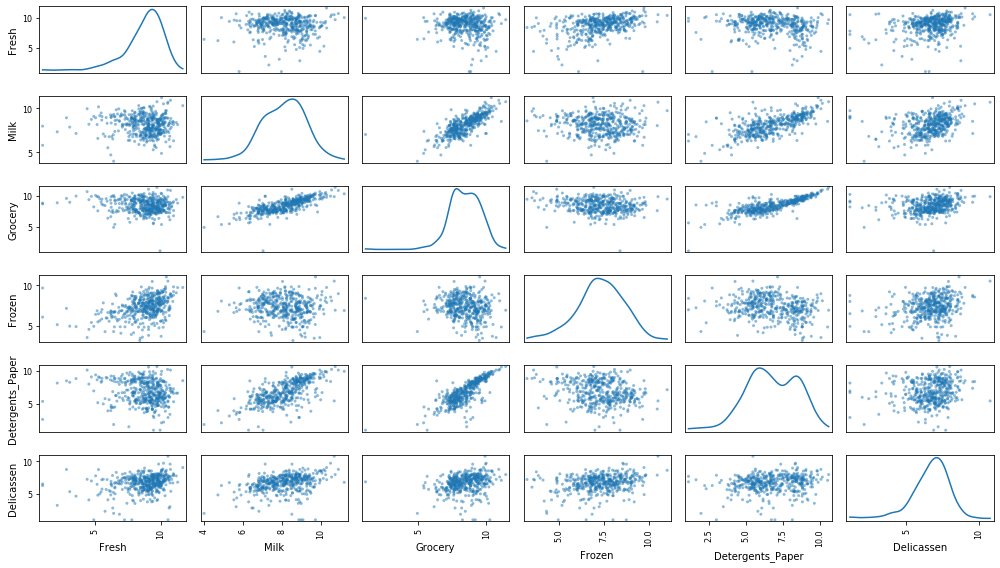

In [41]:
# Scale the data using the natural logarithm
log_data = np.log(data.copy())

# Scale the sample data using the natural logarithm
log_samples = np.log(sample)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha=0.5, figsize=(14,8),diagonal='kde')
plt.tight_layout()

## Observation.
- After applying a natural logarithm scaling to the data, the distribution of each feature appears much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).
- Somehow there is the corelation is present.

In [42]:
# Let's compare the original sample data to the log-transformed sample data
print("Original chosen samples of wholesale customers dataset:")
display(sample)

# Display the log-transformed sample data
print("Log-transformed samples of wholesale customers dataset:")
display(log_samples)

Original chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
22,31276,1917,4469,9408,2381,4334
154,622,55,137,75,7,8
430,3097,4230,16483,575,241,2080


Log-transformed samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
22,10.350606,7.558517,8.404920,9.149316,7.775276,8.374246
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
430,8.038189,8.349957,9.710085,6.354370,5.484797,7.640123


## Implementation: Outlier Detection
- Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal

In [57]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data,25)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    
    Q3 = np.percentile(log_data,75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    IQR = (Q3-Q1)
    # Display the outliers
    from IPython.display import display
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~(log_data[feature] < (Q1 - 1.5 * IQR)) |(log_data[feature] > (Q3 + 1.5 * IQR))])
    
    
        # Select the indices for data points you wish to remove
outlier  = [66, 75, 338, 142, 154, 289]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outlier]).reset_index(drop = True)
good_data.shape

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...
435,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...
435,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...
435,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...
435,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...
435,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


Data points considered outliers for the feature 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...
435,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


(434, 6)

## Feature Transformation
- In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

## Implementation: PCA
- Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can go ahead and apply PCA to the good_data to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In [58]:
from sklearn.decomposition import PCA

In [59]:
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

In [60]:
print(pca.components_)

[[ 0.21392264 -0.39475187 -0.44010253  0.20691301 -0.74192568 -0.10700991]
 [-0.64381547 -0.18576705 -0.11241997 -0.50991866 -0.08727179 -0.52030817]
 [-0.62720898  0.06414633 -0.03758881  0.08806961 -0.2720558   0.72063209]
 [-0.38236666  0.01374015  0.00569147  0.82912144  0.16410724 -0.37309651]
 [ 0.01137444  0.74284767  0.30735768 -0.01142146 -0.54234253 -0.24354333]
 [-0.00374186 -0.50352295  0.83531878  0.04290564 -0.2164462  -0.00182239]]


In [61]:
print(pca.explained_variance_)

[4.52563843 2.78067608 1.13683913 1.0169372  0.46737122 0.19773848]


In [62]:
pca_samples

array([[ 0.10386282, -2.80192323,  0.0745543 ,  0.44428191, -1.37505936,
         0.10828145],
       [ 6.20014668,  7.01961701, -0.94091359, -0.74060463, -0.37897464,
         0.06591127],
       [-0.07803162,  0.40015584,  1.37458722, -1.07255885,  1.04064765,
         1.18583886]])

# K-Means Clustering.

It uses the simailarities in the terms of distance from the mean.
It took random mean and then use that mean and measure the distance from that mean.Afterwards it will create the take the avarge of the nearest data and define new mean.It will continue upto the level at which the MSE or no more similarities present.

In [68]:
from sklearn.preprocessing import StandardScaler

In [70]:
scaler = StandardScaler()
x = scaler.fit_transform(data)

In [64]:
from sklearn.cluster import KMeans

In [67]:
K_means = KMeans(n_clusters=3,init='k-means++',max_iter=100,verbose=0,random_state=42)

In [71]:
K_means.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [74]:
cluster = K_means.labels_

In [76]:
n_cluster = K_means.n_clusters
n_cluster

3

In [77]:
from sklearn.metrics import silhouette_score

In [78]:
score = silhouette_score(x,cluster)  #It exist from -1 to 1 .

In [79]:
score

0.33391714199926514

## Now we are going to use  optimal clustering:-
- In order to get the data cluster in such so we will get minimum mean squred error.

In [84]:
ineria = list()
k_range = range(1,50)
for i in k_range:
    K_means = KMeans(n_clusters=i,init='k-means++',max_iter=100,verbose=0,random_state=42)
    K_means.fit(x)
    Ineria=K_means.inertia_
    ineria.append(Ineria)

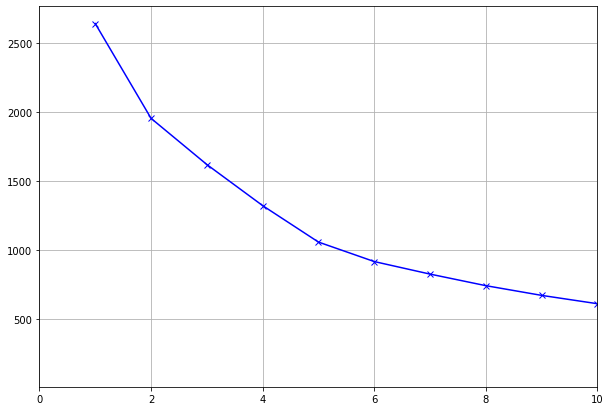

In [103]:
plt.figure(figsize=(10,7))
plt.plot(k_range,ineria,'bx-')
plt.xlim([0,10])
plt.grid()
plt.show()

## Lets do with Optimal Number Of Clusters.

Since,from the above we are considering the only 5 as number of optimal cluster.

In [115]:
K_means = KMeans(n_clusters=6,init='k-means++',max_iter=100,verbose=0,random_state=42)
K_means.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [116]:
optimal_cluster = K_means.labels_

In [117]:
best_score = silhouette_score(x,optimal_cluster)  #It exist from -1 to 1 .

In [118]:
best_score

0.3727781209760862

## Visualization.

In [120]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [121]:
data['Class'] = pd.Series(optimal_cluster)

In [122]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Class
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,2
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,4


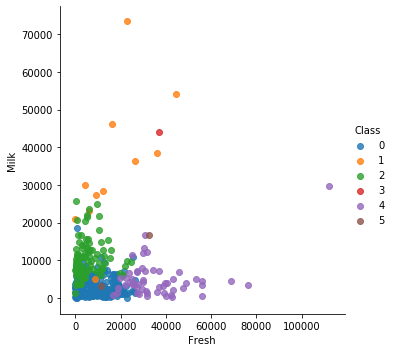

In [129]:
sns.lmplot('Fresh','Milk',data=data,hue='Class',fit_reg=False)
plt.show()

Here we can see the investment on the milk and Fresh is highly dense in the cluster o and 2 as well as cluster 4 showing that it is spreadness of the fresh investment while milk invetsment if conatant about to 0.

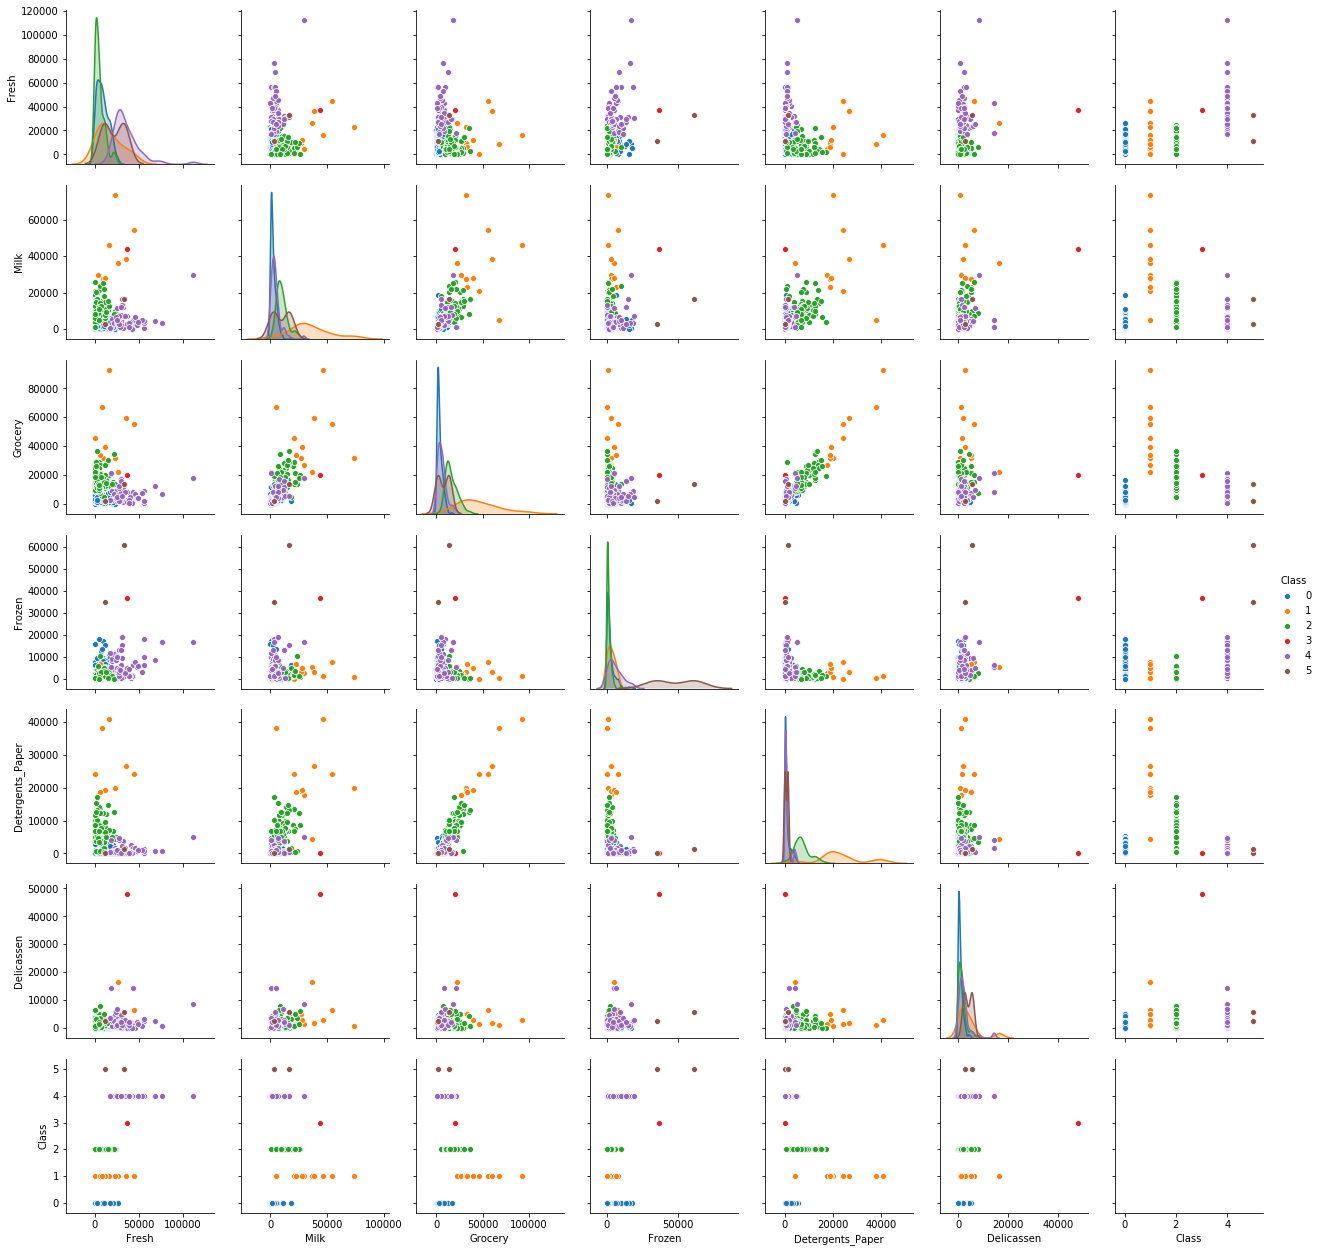

In [131]:
sns.pairplot(data,hue='Class')
plt.show()

## Barplot

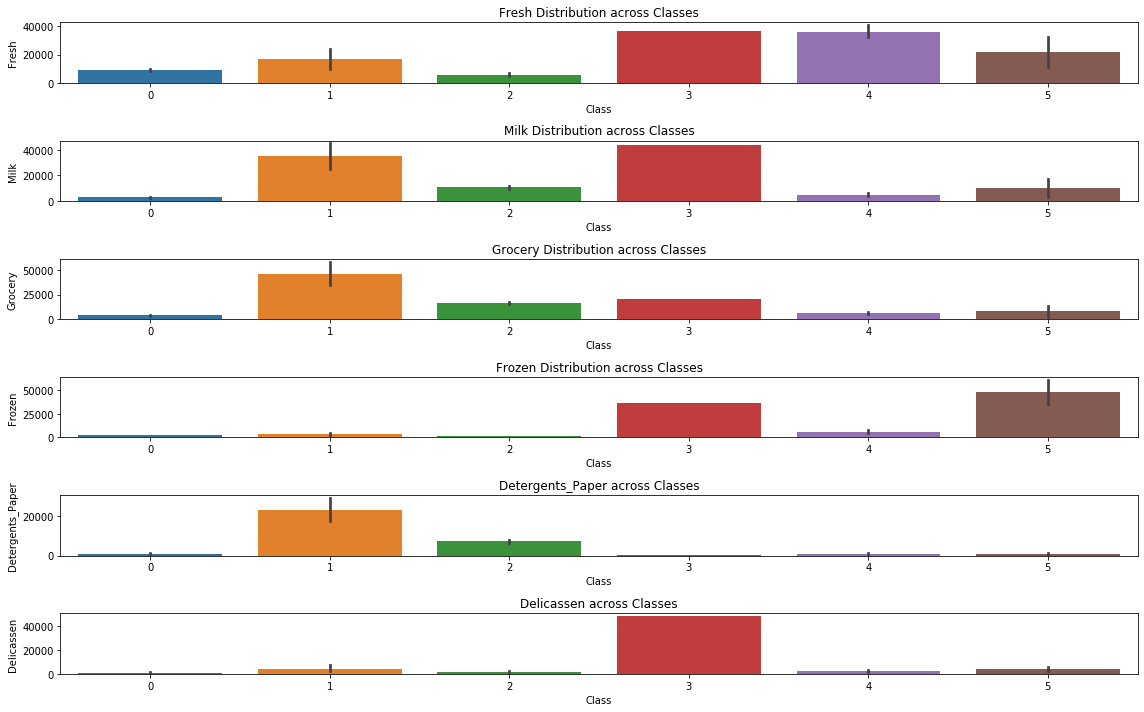

In [135]:
plt.figure(figsize=(16,10))
plt.subplot(611)
sns.barplot(data['Class'],data['Fresh'])
plt.title('Fresh Distribution across Classes')
plt.subplot(612)
sns.barplot(data['Class'],data['Milk'])
plt.title('Milk Distribution across Classes')
plt.subplot(613)
sns.barplot(data['Class'],data['Grocery'])
plt.title('Grocery Distribution across Classes')
plt.subplot(614)
sns.barplot(data['Class'],data['Frozen'])
plt.title('Frozen Distribution across Classes')
plt.subplot(615)
sns.barplot(data['Class'],data['Detergents_Paper'])
plt.title('Detergents_Paper across Classes')
plt.subplot(616)
sns.barplot(data['Class'],data['Delicassen'])
plt.title('Delicassen across Classes')
plt.tight_layout()
plt.show()

We can see from the above how the data is dense accross the classes.Most of the is avalible inside the 1 and 3 class.

Similary, we can multiple visualization by using the Class as a Hue.
# Thank You !!